In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from env.tmaze import TMazeEnv

pybullet build time: Oct  9 2024 16:48:40


In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

> Load agent model (please change the model path in your case)
>> The model can be downloaded at the Release page of this repo:
https://github.com/oist-cnru/The-Bayesian-Behavior-Framework/releases/tag/demo

In [3]:
agent = torch.load("pretrained_agent_example.model", map_location=device)
agent.device = device

> Initialize environment

In [4]:
env = TMazeEnv(mode='GUI', obs='vision', seed=42)

Version = 4.1 Metal - 89.3
Vendor = Apple
Renderer = Apple M3 Max


2024-11-13 14:35:06.419 Python[23136:4625066] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-13 14:35:06.419 Python[23136:4625066] +[IMKInputSession subclass]: chose IMKInputSession_Modern


b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


> Define the goal observation (here use the observation at start position as example)

In [5]:
goal_obs = env.reset()

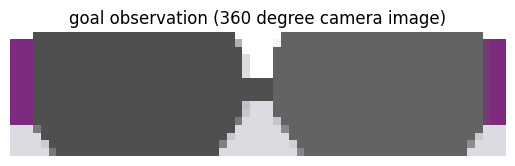

In [6]:

plt.imshow(goal_obs.swapaxes(0,2).swapaxes(0,1))
plt.axis('off')
plt.title("goal observation (360 degree camera image)")
plt.show()

> Run goal-directed planning

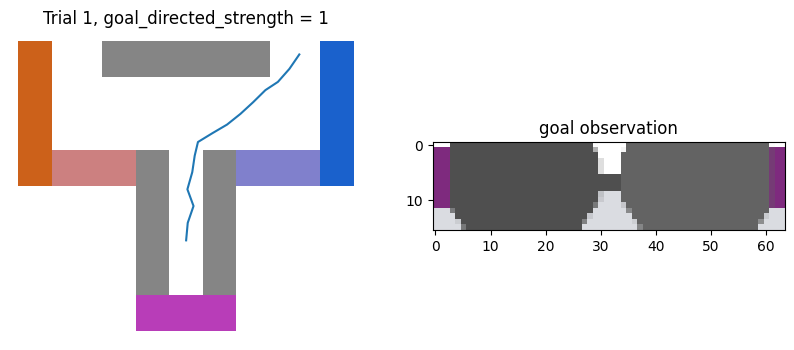

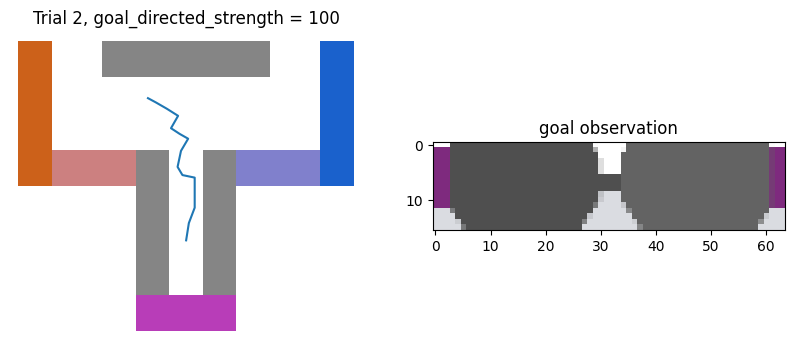

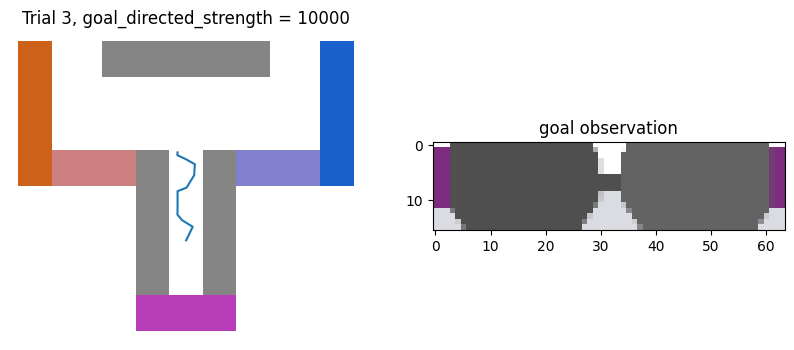

In [7]:
num_trials_planning = 3  

for episode in range(num_trials_planning):
    goal_directed_strength = 100 ** episode  # habitual behavior's constraint is smaller if this value is larger 
    # increasing goal_directed_strength in later trials

    def goal_function(x):
        return goal_directed_strength * torch.sum(((torch.sigmoid(x) - torch.from_numpy(goal_obs).to(device=device)).abs().sum(-3) < 0.25).to(torch.float32), dim=[-1, -2])
    # note this can be changed: basic rule is that the goal function should be smaller if the agent is closer to the goal

    sp = env.reset()
    agent.init_states()
    infos = np.zeros([15 + 1, 2], dtype=np.float32)  # position information
    infos[0] = env.info['ob']

    for t in range(15):
        sp, r, done, info, action = agent.step_with_env(env, sp, goal_obs, behavior='goal-directed', action_return='mean', goal_function=goal_function)     
        # if t == 1:
        #     goal_obs = sp
        infos[t + 1] = info['ob']

    # Visualize trajecotry
    plt.figure(figsize=[10, 4])

    plt.subplot(1,2,1)
    TMazeEnv.draw_tmaze()
    plt.plot(infos[:t + 1, 0], infos[:t + 1, 1])
    plt.title("Trial {}, goal_directed_strength = {}".format(episode + 1, goal_directed_strength))

    plt.subplot(1,2,2)
    plt.imshow(goal_obs.swapaxes(0,2).swapaxes(0,1))
    plt.title("goal observation")
    plt.show()